This Jupyter notebook contains the GNNExplainer method.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from collections import Counter

In [2]:
dataset_nr = 1
assert dataset_nr == 1 or 2

In [3]:
embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

# Load all data

Load the nodes

In [4]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

index_id                         id semantic  \
0             0    WormBase:WBGene00000389     ORTH   
1             1                 ZP:0018675     DISO   
2             2  ZFIN:ZDB-GENE-040426-1197     ORTH   
3             3                          5     DRUG   
4             4                   RGD:3443     ORTH   
...         ...                        ...      ...   
10029     10029                 MP:0009763     DISO   
10030     10030                 MP:0011057     DISO   
10031     10031                 MP:0001412     DISO   
10032     10032        WBPhenotype:0004023     DISO   
10033     10033      ClinVarVariant:858516     VARI   

                                                   label  semantic_id  
0                                               cdc-25.4            5  
1      right side lateral plate mesoderm mislocalised...            1  
2                                                 tbc1d5            5  
3                                        (S)-nicardipine            2  
4                                                   Ptk2            5  
...                                                  ...          ...  
10029  increased sensitivity to induced morbidity/mor...            1  
10030                 absent brain ependyma motile cilia            1  
10031                               excessive scratching            1  
10032                     frequency of body bend variant            1  
10033          NM_004006.3(DMD):c.9852G>A (p.Trp3284Ter)            7  

[10034 rows x 5 columns]

In [5]:
nodes.iloc[5487]

index_id            5487
id             HGNC:6717
semantic            GENE
label              LTBP4
semantic_id            3
Name: 5487, dtype: object

In [6]:
node_labels_dict = nodes[['semantic_id', 'semantic']].drop_duplicates().set_index('semantic_id').to_dict()['semantic']
node_labels_dict

{5: 'ORTH',
 1: 'DISO',
 2: 'DRUG',
 4: 'GENO',
 7: 'VARI',
 3: 'GENE',
 0: 'ANAT',
 6: 'PHYS'}

Load the node embeddings

In [7]:
def loadEdge2VecEmbedding(): 
    node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

def loadMetapath2VecEmbedding():
    metapath2vec_embedding = pd.read_csv(f'output/metapath2vec_embedding_{dataset_nr}.csv')
    metapath2vec_embedding['Embedding'] = metapath2vec_embedding.values.tolist()
    metapath2vec_embedding = metapath2vec_embedding[['Embedding']]
    metapath2vec_embedding['Node'] = metapath2vec_embedding.index
    return metapath2vec_embedding[['Node', 'Embedding']]

In [8]:
if embedding_method == 'e2v':
    embedding = loadEdge2VecEmbedding()
else:
    embedding = loadMetapath2VecEmbedding()
    
embedding

Node                                          Embedding
0          0  [-0.09041356, -0.6655479, -0.14612436, 1.32871...
1          1  [-0.0075429436, -0.3465976, 0.19532959, 0.3948...
2          2  [0.14468032, -0.0011031462, 0.7293711, -0.0451...
3          3  [-0.015362108, -0.34448814, 0.1134375, 0.41494...
4          4  [0.1177432, 0.18739936, 0.44894883, 0.02960052...
...      ...                                                ...
10029  10029  [-0.19342971, -0.27357644, 0.26208302, 0.38209...
10030  10030  [-0.08411312, -0.1981778, 0.25944984, 0.383525...
10031  10031  [-0.182369, -0.28869572, 0.15757065, 0.4029619...
10032  10032  [0.11017755, -0.4436196, -0.21446034, 0.485063...
10033  10033  [-0.0024427539, -0.17568794, 0.20432216, 0.299...

[10034 rows x 2 columns]

Load the edges

In [9]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

head             label_head  class_head  \
0      ZFIN:ZDB-GENE-050626-112                   myl4           5   
1      ZFIN:ZDB-GENE-050626-112                   myl4           5   
2      ZFIN:ZDB-GENE-050626-112                   myl4           5   
3      ZFIN:ZDB-GENE-050626-112                   myl4           5   
4      ZFIN:ZDB-GENE-050626-112                   myl4           5   
...                         ...                    ...         ...   
82908                      4810              ibrutinib           2   
82909                       522             carvedilol           2   
82910          OMIM:300377.0013           DMD, EX18DEL           1   
82911           Coriell:GM05113          NIGMS-GM05113           4   
82912          OMIM:300377.0039  DMD, 1-BP INS, NT1554           1   

       index_head                               relation  \
0            5279         in orthology relationship with   
1            5279         in orthology relationship with   
2            5279         in orthology relationship with   
3            5279         in orthology relationship with   
4            5279  in 1 to 1 orthology relationship with   
...           ...                                    ...   
82908        1618                                targets   
82909         184                                targets   
82910        2822                           is allele of   
82911        8105                   has role in modeling   
82912        7364                           is allele of   

                             tail                   label_tail  class_tail  \
0             FlyBase:FBgn0085464                      CG34435           5   
1                       HGNC:7585                         MYL4           3   
2             FlyBase:FBgn0002772                         Mlc1           5   
3                 NCBIGene:396472                         MYL4           3   
4      ENSEMBL:ENSECAG00000020967   ENSEMBL:ENSECAG00000020967           5   
...                           ...                          ...         ...   
82908                  HGNC:11283                          SRC           3   
82909                    HGNC:620                          APP           3   
82910                   HGNC:2928                          DMD           3   
82911               MONDO:0010679  Duchenne muscular dystrophy           1   
82912                   HGNC:2928                          DMD           3   

       index_tail  type  
0            6825     0  
1              27     0  
2            8901     0  
3            9508     0  
4            8807     1  
...           ...   ...  
82908        3279    14  
82909         547    14  
82910        6612    16  
82911        6315    15  
82912        6612    16  

[82913 rows x 10 columns]

Initialize a graph with edges and nodes including the embedding features of each node.

In [10]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([-0.0904, -0.6655, -0.1461,  1.3287, -0.1799, -0.6368,  0.5866,  0.1622,
        -0.1975,  0.4096, -0.3218, -0.0040, -0.0076, -0.5666,  0.0558,  0.4756,
        -0.6627,  0.1069,  0.0195,  0.4384,  0.1462,  1.0030,  0.2532, -0.9624,
         0.2151, -0.1681,  0.0752, -0.6384,  0.6718, -0.7139, -0.3339,  0.6320])})
(0, 5765, {'edge_label': 'interacts with'})
Number of edges is 52024
Number of nodes is 10034


In [11]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 5765): 'interacts with',
 (0, 1681): 'in orthology relationship with',
 (0, 8615): 'in orthology relationship with',
 (0, 363): 'in orthology relationship with',
 (0, 5156): 'in orthology relationship with',
 (0, 8473): 'in orthology relationship with',
 (0, 6666): 'in orthology relationship with',
 (0, 5248): 'in 1 to 1 orthology relationship with',
 (0, 3961): 'in orthology relationship with',
 (0, 9835): 'in 1 to 1 orthology relationship with',
 (0, 2619): 'in orthology relationship with',
 (0, 8756): 'in orthology relationship with',
 (0, 1856): 'in orthology relationship with',
 (0, 3670): 'in 1 to 1 orthology relationship with',
 (0, 10028): 'in 1 to 1 orthology relationship with',
 (0, 6308): 'in orthology relationship with',
 (0, 2226): 'in orthology relationship with',
 (0, 8710): 'in orthology relationship with',
 (0, 5949): 'in orthology relationship with',
 (0, 2139): 'in orthology relationship with',
 (0, 9308): 'has phenotype',
 (0, 71): 'has phenotype',
 (1, 6012): 

Load trained model

In [15]:
from gnn.linkpred_model import LinkPredModel

with open(f'output/best_model_{dataset_nr}_{embedding_method}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}_{embedding_method}.pth'))

<All keys matched successfully>

# Explain predictions

In [16]:
x = torch.Tensor(embedding['Embedding'])
print(x.shape)

torch.Size([10034, 32])


In [17]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 52024])


In [18]:
nx.is_directed(G)

False

In [19]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

num_hops = 1

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=num_hops, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        if nx.has_path(G2, node_idx1, node_idx2) and torch.is_nonzero(limit):
            trigger = True
            
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [21]:
import ast

symptoms_drugs = pd.read_csv(f'output/symptom_drugs_{dataset_nr}_{embedding_method}.csv', converters={1:ast.literal_eval})
symptoms_drugs

Symptom         Candidates
0   HP:0011675   [1576, 626, 305]
1   HP:0002515  [2835, 522, 4818]
2   HP:0003236  [2835, 522, 1576]
3   HP:0002093  [2835, 522, 4818]
4   HP:0003707   [2835, 305, 522]
5   HP:0001256  [2835, 522, 4818]
6   HP:0003701  [2835, 522, 4818]
7   HP:0003202  [2835, 522, 4818]
8   HP:0003560   [626, 2835, 522]
9   HP:0003391  [2835, 522, 4818]
10  HP:0001635  [1576, 606, 2666]
11  HP:0001328  [2835, 522, 4818]
12  HP:0003323  [626, 2835, 1576]
13  HP:0001371  [2835, 522, 4818]
14  HP:0002650  [2835, 522, 4818]
15  HP:0003115  [1576, 305, 5408]
16  HP:0001263  [2835, 522, 4818]
17  HP:0008981  [2835, 522, 4818]
18  HP:0001638  [1576, 626, 2835]
19  HP:0003307  [2835, 522, 4818]
20  HP:0000750  [2835, 522, 4818]
21  HP:0001265  [2835, 522, 4818]
22  HP:0001644  [2835, 1576, 522]
23  HP:0001270  [2835, 522, 4818]
24  HP:0001290  [2835, 522, 4818]
25  HP:0100543  [2835, 522, 4818]
26  HP:0002791  [305, 2835, 5408]

In [23]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 447.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 518.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 489.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 504.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 526.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 525.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 534.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 529.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 518.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 530.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 533.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 522.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 523.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 522.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 534.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 524.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 527.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 514.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 518.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 522.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 531.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 475.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 502.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 526.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 505.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 533.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 526.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 528.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 519.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 529.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 519.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 531.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 509.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 527.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 523.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 525.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 534.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 514.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 523.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 513.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 523.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 495.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 484.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 533.38it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id   id semantic          label  semantic_id
209       209  626     DRUG  chlorzoxazone            2
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 511.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 514.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 518.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 508.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 528.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 516.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 517.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 513.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 517.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 526.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 533.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 525.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 524.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 520.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 528.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 479.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 511.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 518.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 528.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 522.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 485.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 502.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 527.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 514.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 491.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 524.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 521.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 514.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 529.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 518.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 524.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 519.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 453.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 465.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 417.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 377.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:02<00:00, 349.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 371.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 430.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:02<00:00, 316.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 417.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 438.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 427.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 462.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 425.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 411.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 476.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 459.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 462.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 209: 100%|██████████| 700/700 [00:01<00:00, 442.54it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id   id semantic                label  semantic_id
118       118  305     DRUG  bendroflumethiazide            2
Prediction from trained model: tensor([0.5635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 435.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 423.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 452.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 437.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 460.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 455.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 443.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 457.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 459.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 437.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 455.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 426.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 428.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 431.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 446.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 433.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 464.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 439.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 497.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 491.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 490.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 502.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 516.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 514.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 520.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 520.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 516.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 510.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 524.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 524.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 525.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 508.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 475.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 499.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 517.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 506.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 516.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 513.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 453.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 458.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 467.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 483.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 491.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 500.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 479.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 435.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 438.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 432.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 427.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 118: 100%|██████████| 700/700 [00:01<00:00, 472.66it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 586.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 572.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 574.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 567.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 542.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 560.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 551.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 553.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 567.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 558.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 574.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 552.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 550.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 567.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 579.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 546.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 577.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 592.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 560.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 537.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 560.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 539.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 573.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 570.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 576.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 524.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 580.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 555.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 522.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 555.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 514.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 548.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 549.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 453.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 516.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 530.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 479.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 519.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 963: 100%|██████████| 700/700 [00:01<00:00, 468.25it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 480.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 461.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 486.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 461.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 508.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 534.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 543.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 497.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 490.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 471.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 478.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 529.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 478.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 542.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 514.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 503.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 414.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 528.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 514.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 524.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 551.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 508.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 541.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:02<00:00, 332.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 501.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 451.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 384.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 418.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 402.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 411.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 433.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 445.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 498.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 462.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 439.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 490.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 500.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 477.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 445.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 483.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 450.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 483.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 184: 100%|██████████| 700/700 [00:01<00:00, 483.94it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.5627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 529.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 456.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 495.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 503.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 539.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 531.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 462.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 539.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 533.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 542.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 573.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 554.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 508.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 511.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 564.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 568.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 586.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 584.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 612.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 547.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 589.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 592.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 570.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 536.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 588.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 571.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 590.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 526.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 538.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 599.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 579.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 599.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 584.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 496.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 620.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 586.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 577.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1622: 100%|██████████| 700/700 [00:01<00:00, 589.15it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 551.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 541.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 529.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 528.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 566.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 493.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 516.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 559.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 540.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 551.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 541.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 549.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 532.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 542.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 570.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 492.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 552.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 532.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 543.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 549.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 543.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 530.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 559.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 506.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 516.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 548.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 514.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 536.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 554.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 584.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 587.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 498.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 529.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 488.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 509.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 514.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 517.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 436.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 489.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 963: 100%|██████████| 700/700 [00:01<00:00, 498.16it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 492.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 515.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 456.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 464.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 485.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 484.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 425.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 476.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 544.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 553.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 561.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 544.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 546.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 565.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 535.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 551.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 184: 100%|██████████| 700/700 [00:01<00:00, 550.10it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.6431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 516.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 549.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 578.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 562.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 567.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 566.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 567.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 562.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 560.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 548.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 556.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 560.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 563.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 559.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 572.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 538.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 527.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 506.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 537.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 536.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 553.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 563.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 558.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 545.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 538.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 563.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 555.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 563.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 549.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 547.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 578.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 531.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 559.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 565.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 551.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 549.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 541.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 543.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.51it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 963: 100%|██████████| 700/700 [00:01<00:00, 505.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 963: 100%|██████████| 700/700 [00:01<00:00, 518.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 963: 100%|██████████| 700/700 [00:01<00:00, 525.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 963: 100%|██████████| 700/700 [00:01<00:00, 506.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 963: 100%|██████████| 700/700 [00:01<00:00, 503.52it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 517.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.00it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 497.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 494.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 488.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 501.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 532.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 537.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 477.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 495.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 535.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 515.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 516.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 537.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 535.99it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 524.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 520.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 507.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 524.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 525.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 506.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 477.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 495.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 509.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 513.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 521.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 521.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 543.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 499.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 536.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.78it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.9419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 517.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 533.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 540.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 537.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 525.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 533.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 515.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1622: 100%|██████████| 700/700 [00:01<00:00, 516.28it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.6549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 611.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 560.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 623.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 602.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 613.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 622.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 613.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 632.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 618.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 622.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 600.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 618.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 602.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 603.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 608.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 534.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 580.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 585.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 576.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 611.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 625.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 605.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 603.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 607.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 597.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 627.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.33it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
     index_id   id semantic                label  semantic_id
118       118  305     DRUG  bendroflumethiazide            2
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 610.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 623.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 632.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 610.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 646.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 605.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 583.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 627.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 623.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 653.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 646.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 629.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 623.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 626.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 635.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 637.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 629.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 629.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 629.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 648.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 634.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 638.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 656.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 595.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 603.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 587.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 647.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 619.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 619.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 645.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 621.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 635.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 639.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 648.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 633.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 640.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 604.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 638.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 656.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 615.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 647.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 634.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 629.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 644.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 641.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 600.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 620.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 621.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 568.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 594.49it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 627.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 637.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 640.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 619.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 614.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 616.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 629.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 638.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 632.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 615.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 626.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 637.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 626.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 631.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 612.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 616.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 619.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 626.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 621.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 652.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 611.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 627.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 540.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.81it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.6780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 591.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 574.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 593.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 596.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 561.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 611.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 600.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 576.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 591.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 539.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 551.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 579.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 583.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 600.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 597.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 537.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 599.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 608.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 590.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 602.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 605.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 581.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 577.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 598.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 578.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 572.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 563.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 595.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 583.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 602.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 614.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 546.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 564.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 563.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 533.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 519.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 546.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 558.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 963: 100%|██████████| 700/700 [00:01<00:00, 552.83it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 621.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 640.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 618.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 615.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 618.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 629.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 633.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 632.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 660.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 686.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 628.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 625.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 632.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 659.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 632.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 557.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 628.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 635.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 634.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 184: 100%|██████████| 700/700 [00:01<00:00, 640.51it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.6313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 532.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 561.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 570.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 584.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 602.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 568.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 608.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 599.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 573.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 573.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 643.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 537.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 583.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 609.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 641.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 608.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 612.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 609.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 570.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 495.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 545.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 594.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 558.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 562.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 598.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 526.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 405.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 529.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 548.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 655.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 623.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 586.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.25it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.9015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 510.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 577.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 467.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 542.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 533.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 539.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 556.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 509.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 505.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 530.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 448.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 364.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 515.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 506.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 560.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8923], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 553.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 544.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 500.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 514.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 479.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 505.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 436.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 550.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 573.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 546.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 551.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 538.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 504.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 441.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 465.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 536.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 517.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 462.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 499.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 532.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 524.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 522.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 495.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 524.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 525.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 516.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 530.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 520.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 512.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 484.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 963: 100%|██████████| 700/700 [00:01<00:00, 539.55it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.5649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 539.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 435.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 545.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 532.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 477.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 491.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 495.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 394.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 521.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 529.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 529.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 444.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 540.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 528.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 374.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 444.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 525.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 452.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 420.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 493.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 494.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 482.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 444.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 450.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 461.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 469.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 451.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 511.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 516.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 537.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 440.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 493.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.05it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 552.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 542.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 440.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 625.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 619.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 612.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 602.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 619.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 622.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 565.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 589.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 608.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 619.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 569.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 618.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 627.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 622.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1622: 100%|██████████| 700/700 [00:01<00:00, 622.35it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 963: 100%|██████████| 700/700 [00:01<00:00, 536.42it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.4710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 611.50it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 612.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 595.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.30it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 606.94it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 597.90it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 615.22it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 609.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 627.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 606.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.11it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.83it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.47it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.2814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 500.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 540.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 508.49it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.08it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.3438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 606.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.88it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.34it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.3686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.25it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.18it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.7751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.39it/s]


Contribution threshold is tensor(0.0062)
Explanation found!
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
     index_id   id semantic          label  semantic_id
209       209  626     DRUG  chlorzoxazone            2
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 584.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 574.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 586.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 578.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 577.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 571.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 586.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 577.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 568.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 559.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 568.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 579.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 583.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 547.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 529.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 582.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 584.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:02<00:00, 313.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:02<00:00, 283.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 399.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 403.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 378.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:02<00:00, 349.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 401.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 425.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 404.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 482.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 388.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 473.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 479.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 473.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 474.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 517.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 507.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 516.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 492.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 484.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 502.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 495.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 472.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 524.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 500.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 536.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 534.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 443.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 540.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 526.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 524.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 509.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 209: 100%|██████████| 700/700 [00:01<00:00, 546.85it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 527.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 511.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 505.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 521.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 532.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 525.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 516.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 482.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 483.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 530.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 538.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 515.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 515.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 507.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 532.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 526.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 536.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5923], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 545.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 526.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 533.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 524.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 507.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 533.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 502.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 526.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 520.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 522.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 514.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 495.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 489.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 519.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 501.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 536.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 528.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 511.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 541.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 517.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 509.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 519.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 481.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 537.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 521.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 963: 100%|██████████| 700/700 [00:01<00:00, 523.14it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.3008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 532.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 520.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 541.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 487.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 513.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 513.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 532.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 522.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 540.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 536.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 543.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 530.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 525.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 539.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 440.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 434.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 517.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 529.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 502.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 525.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 548.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 546.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 517.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 525.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 528.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 520.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 494.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 184: 100%|██████████| 700/700 [00:01<00:00, 501.76it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 598.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 579.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 600.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 615.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 605.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 613.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 605.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 581.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 593.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 596.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 585.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 599.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 597.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 597.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 602.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 598.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 608.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 607.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 592.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 534.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 594.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 450.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 615.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 632.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 673.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 659.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 645.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 669.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 658.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 675.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 645.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 649.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 656.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 650.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 963: 100%|██████████| 700/700 [00:01<00:00, 585.47it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.4545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 615.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 663.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 671.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 659.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 664.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 669.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 672.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 673.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 632.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 671.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 676.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 671.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 681.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 671.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 660.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 672.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 652.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 651.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 465.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 625.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 448.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 557.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 184: 100%|██████████| 700/700 [00:01<00:00, 556.68it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.7597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 620.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 582.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 590.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 593.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 609.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 586.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 633.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 609.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 560.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 556.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 602.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 597.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 608.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 535.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 574.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 593.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 599.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 617.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 533.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 640.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 578.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 545.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 527.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 488.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 636.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 603.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 568.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 592.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 584.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 572.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1622: 100%|██████████| 700/700 [00:01<00:00, 548.53it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 430.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 425.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 430.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 462.07it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 483.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 423.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 494.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 459.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 487.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 469.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 480.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 479.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 483.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 506.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 496.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 469.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 482.38it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 443.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 449.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 492.01it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 496.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 480.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 489.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 470.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 492.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 483.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 487.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 477.27it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 479.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 494.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 483.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 507.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 475.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 497.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 473.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 478.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 442.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 474.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 475.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 475.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 504.33it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 502.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 470.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 493.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 488.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 517: 100%|██████████| 700/700 [00:01<00:00, 477.17it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 486.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 483.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 490.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 490.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 478.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 458.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 420.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 435.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 457.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 449.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 439.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 428.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 415.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 446.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 417.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 467.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 526.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 514.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 418.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 450.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 458.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 443.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 481.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 481.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 460.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 490.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 473.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 435.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 464.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 448.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 436.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 475.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 469.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 489.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.86it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id    id semantic            label  semantic_id
891       891  2666     DRUG  tiludronic acid            2
Prediction from trained model: tensor([0.5055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 497.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 500.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 496.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 431.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 357.78it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 384.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 360.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 376.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 406.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 460.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 461.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 492.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 441.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 501.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 494.90it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 503.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 492.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 506.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 490.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 508.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 496.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 485.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 485.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 502.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 483.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 490.21it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 472.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 486.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 499.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 472.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 509.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 495.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 497.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 476.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 487.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 484.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 508.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 506.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 495.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 486.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 501.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 492.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 488.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 508.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 485.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 493.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 490.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 483.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 457.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 891: 100%|██████████| 700/700 [00:01<00:00, 506.84it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 620.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 628.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 629.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 649.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 627.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 625.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 625.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 659.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 605.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 561.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 624.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 625.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 629.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 609.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 629.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 629.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 595.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 636.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 610.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 552.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 963: 100%|██████████| 700/700 [00:01<00:00, 627.90it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.5834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 620.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 649.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 609.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 479.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 637.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 618.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 611.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 624.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 628.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 620.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 636.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 613.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 628.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 628.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 625.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 636.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 638.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 630.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.66it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 647.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 623.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 623.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 625.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 636.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 642.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 658.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 644.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 617.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 623.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 635.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 626.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 633.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 664.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 565.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 626.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 650.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 615.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 569.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 626.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 645.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 628.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 637.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 652.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 643.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 628.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 631.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 628.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 631.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 631.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 643.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 588.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.02it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
     index_id   id semantic          label  semantic_id
209       209  626     DRUG  chlorzoxazone            2
Prediction from trained model: tensor([0.4239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 679.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 696.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 666.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 668.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 673.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 690.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 668.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 685.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 687.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 697.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 666.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:00<00:00, 713.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 689.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 689.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 679.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 692.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 694.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 674.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 692.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 622.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 622.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 682.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 668.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 673.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 659.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 683.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 691.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 679.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 698.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 651.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:00<00:00, 701.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 697.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 681.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 670.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:00<00:00, 711.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 692.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 677.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 686.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 671.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:00<00:00, 711.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 658.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 644.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 696.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:00<00:00, 709.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 659.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 681.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 679.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 686.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 642.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 209: 100%|██████████| 700/700 [00:01<00:00, 644.01it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.5392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 498.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 590.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 588.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 671.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 667.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 635.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 650.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 676.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 676.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 674.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 586.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 589.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 666.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 673.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 649.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:00<00:00, 700.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 677.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 673.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 963: 100%|██████████| 700/700 [00:01<00:00, 574.36it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.4270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 605.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 693.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 695.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 668.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 696.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:00<00:00, 705.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 671.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 693.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 685.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 675.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 677.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:00<00:00, 712.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 686.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 673.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 679.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:00<00:00, 707.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 656.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 684.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 646.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 678.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 663.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 680.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 670.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 605.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 583.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 679.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 658.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 687.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:00<00:00, 701.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 669.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 686.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 655.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 683.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 666.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 697.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 663.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 697.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 684.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 679.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 676.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 671.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 666.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 694.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 694.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 676.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 652.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 685.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 517: 100%|██████████| 700/700 [00:00<00:00, 722.17it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 601.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 656.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 679.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 669.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 640.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 649.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 677.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 628.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 603.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 654.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 656.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 641.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 654.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 664.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 632.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 656.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 628.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 658.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.53it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.5227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 674.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 635.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 622.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 670.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 673.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 655.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 623.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 660.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 509.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 617.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 515.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 533.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 614.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 616.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 627.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 593.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 637.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 620.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 638.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 597.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 623.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 621.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 626.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.63it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 629.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 564.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 611.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 616.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 591.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 637.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 531.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 549.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 598.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 622.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 626.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 466.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 524.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 608.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 599.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 604.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 592.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 590.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 574.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 620.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 557.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 582.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 622.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 619.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 591.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 605.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 591.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 589.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 640.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 600.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 585.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 602.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 597.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 598.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 613.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 607.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1622: 100%|██████████| 700/700 [00:01<00:00, 610.94it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.9338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 963: 100%|██████████| 700/700 [00:01<00:00, 556.48it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 527.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 549.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 559.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 555.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 557.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 515.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 559.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 578.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 520.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.29it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 553.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 549.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 561.86it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 520.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 184: 100%|██████████| 700/700 [00:01<00:00, 561.76it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.9309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1622: 100%|██████████| 700/700 [00:01<00:00, 586.70it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 645.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 637.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 650.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 622.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 606.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 669.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 676.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 607.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 652.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 661.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 670.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 651.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 642.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 649.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 622.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 635.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 641.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 633.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 617.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 534.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 646.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 565.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 551.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 528.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 514.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 473.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 627.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 665.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 674.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 518.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 526.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 536.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 457.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 617.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 511.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 620.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 628.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 639.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 610.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 628.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 623.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 629.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 555.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 533.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 601.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 521.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 543.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 524.74it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
     index_id   id semantic                label  semantic_id
118       118  305     DRUG  bendroflumethiazide            2
Prediction from trained model: tensor([0.6204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 524.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 646.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 515.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 541.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 638.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 651.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 658.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 664.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 644.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 660.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 654.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 664.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 652.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 654.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 675.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 669.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 650.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 656.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 613.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 624.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 640.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 645.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 649.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 664.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 661.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 666.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 658.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 655.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 645.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 657.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 658.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 638.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 658.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 647.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 665.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 644.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 654.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 652.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 677.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 665.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 640.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 654.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 643.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 660.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 611.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 625.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 643.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 654.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 657.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 118: 100%|██████████| 700/700 [00:01<00:00, 635.86it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
      index_id    id semantic        label  semantic_id
1821      1821  5408     DRUG  viltolarsen            2
Prediction from trained model: tensor([0.7393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 679.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 653.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 666.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 652.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 570.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 654.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 672.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 668.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 665.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 667.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 649.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 672.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 664.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 651.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 638.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 651.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 671.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 647.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 654.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 580.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 599.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 655.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 640.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 673.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 666.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 657.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 653.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 647.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 654.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 668.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 651.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 632.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 680.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 656.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 664.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 668.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 651.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 672.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 659.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 660.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 666.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 654.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 656.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 670.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 603.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 636.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 644.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 649.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 665.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1821: 100%|██████████| 700/700 [00:01<00:00, 652.46it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.9157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 963: 100%|██████████| 700/700 [00:01<00:00, 502.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 963: 100%|██████████| 700/700 [00:01<00:00, 507.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 963: 100%|██████████| 700/700 [00:01<00:00, 517.58it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 512.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 514.44it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 505.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 513.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 507.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 512.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 515.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.55it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 503.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.38it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 507.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 514.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 482.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 184: 100%|██████████| 700/700 [00:01<00:00, 494.93it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 502.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 508.96it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 513.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 495.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 514.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 506.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1622: 100%|██████████| 700/700 [00:01<00:00, 509.75it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 636.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 637.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 635.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 654.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 587.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 603.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 615.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 622.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 627.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 636.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 636.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 641.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 629.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 564.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 620.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 644.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 649.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 645.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 641.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 635.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.35it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.4637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 659.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 662.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 655.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 649.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 639.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 660.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 649.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 647.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 614.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 658.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 634.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 653.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 647.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 665.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 665.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 642.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 663.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 634.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 647.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 634.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 631.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 646.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 184: 100%|██████████| 700/700 [00:01<00:00, 634.30it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 625.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 639.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 648.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 642.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 623.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 647.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 642.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 641.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 627.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 637.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 642.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 628.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 637.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 577.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 636.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 640.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 609.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 649.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 631.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 647.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 639.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 637.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 640.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 643.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 628.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 631.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 639.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 614.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 640.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 630.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 551.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 624.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 643.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 635.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 635.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1622: 100%|██████████| 700/700 [00:01<00:00, 638.12it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 630.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 596.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 598.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 603.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 636.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 651.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 638.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 643.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 631.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 644.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 633.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 634.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 635.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 536.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 585.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 562.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 622.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 639.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 639.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 636.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 552.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 642.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 632.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 658.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 621.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 646.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 640.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 615.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 640.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 631.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 648.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 635.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 644.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 629.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 643.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 626.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 553.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 580.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 645.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 639.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 646.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 640.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 638.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 517: 100%|██████████| 700/700 [00:01<00:00, 611.09it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
     index_id   id semantic          label  semantic_id
209       209  626     DRUG  chlorzoxazone            2
Prediction from trained model: tensor([0.6387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 622.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 647.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 622.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 627.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 639.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 659.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 637.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 642.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 616.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 647.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 622.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 631.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 644.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 633.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 632.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 605.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 605.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 608.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 640.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 628.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 626.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 645.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 645.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 651.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 647.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 651.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 631.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 645.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 629.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 620.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 609.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 634.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 636.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 641.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 643.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 636.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 607.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 630.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 643.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 626.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 629.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 576.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 619.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 629.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 637.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 659.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 650.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 613.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 626.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 209: 100%|██████████| 700/700 [00:01<00:00, 647.82it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.6278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 628.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 620.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 606.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 592.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 613.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 604.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 628.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 611.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 623.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 591.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 567.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 597.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 632.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 609.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 618.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 622.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 616.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 609.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 618.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 627.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 617.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 614.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 637.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 620.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 544.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 594.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 638.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 621.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 631.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 614.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 620.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 618.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.53it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 963: 100%|██████████| 700/700 [00:01<00:00, 586.29it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.4801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5923], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 523.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 540.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.07it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 551.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 549.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.97it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.7216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 579.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 562.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 564.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 578.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 577.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 571.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 565.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1622: 100%|██████████| 700/700 [00:01<00:00, 589.75it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 963: 100%|██████████| 700/700 [00:01<00:00, 535.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 963: 100%|██████████| 700/700 [00:01<00:00, 538.07it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.43it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.53it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 550.11it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.15it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 609.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.89it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 593.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 590.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 597.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 557.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.26it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.9068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1622: 100%|██████████| 700/700 [00:01<00:00, 579.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1622: 100%|██████████| 700/700 [00:01<00:00, 601.64it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 963: 100%|██████████| 700/700 [00:01<00:00, 548.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 963: 100%|██████████| 700/700 [00:01<00:00, 554.82it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.4705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 587.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 565.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 535.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 521.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 565.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 555.64it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 553.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 531.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.09it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.6925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1622: 100%|██████████| 700/700 [00:01<00:00, 562.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1622: 100%|██████████| 700/700 [00:01<00:00, 579.22it/s]


Contribution threshold is tensor(0.9937)
Explanation found!
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 565.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 552.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 562.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 583.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 585.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.46it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 570.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 540.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 531.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 501.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 564.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 559.25it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 558.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 576.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 570.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 563.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 553.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 566.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 564.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 568.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 557.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 574.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 569.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 570.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 565.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 573.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 578.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 517.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 494.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 563.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 581.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 567.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 547.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 563.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 544.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 543.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 572.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 556.95it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 565.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 571.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 963: 100%|██████████| 700/700 [00:01<00:00, 564.66it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.5793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 590.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 565.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 581.81it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 582.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 566.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 531.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 523.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 574.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.43it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.02it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 561.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 570.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 564.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 576.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.53it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 561.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 566.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 590.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 561.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 576.36it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 577.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 580.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 570.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 573.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 582.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 544.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 556.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 579.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 552.11it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 565.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 568.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 571.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 574.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 576.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 585.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 574.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 552.42it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 581.20it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 517: 100%|██████████| 700/700 [00:01<00:00, 559.02it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.2656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 518.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 538.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 555.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.2546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 565.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.12it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 561.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.15it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 566.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.2954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 576.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 510.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 552.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.95it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 564.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 565.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 567.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.74it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 569.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 572.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 570.86it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 562.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.96it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 571.16it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.05it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.41it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.7998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 612.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 643.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6866], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 641.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 650.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 634.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 624.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 622.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 624.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 652.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 656.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 619.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 645.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 657.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 646.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 633.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 648.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 667.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 963: 100%|██████████| 700/700 [00:01<00:00, 653.54it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 651.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 655.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 663.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 659.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 643.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 672.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 670.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 660.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 664.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 655.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 665.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 665.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 653.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 669.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 666.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 655.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 659.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 648.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 652.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 664.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 674.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 673.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 649.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 668.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 656.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 650.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 654.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 664.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 661.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 657.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 645.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 644.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 652.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 641.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 184: 100%|██████████| 700/700 [00:01<00:00, 678.16it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.6475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 617.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 626.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 650.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 651.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 658.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 648.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 664.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 634.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 657.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 658.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 649.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 660.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 649.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 649.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 652.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 652.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 660.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 658.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 641.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 666.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 593.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 668.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 648.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 658.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 652.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 648.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 644.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 665.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 676.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 653.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 656.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 651.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 666.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 646.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 632.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 642.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 661.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 647.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 644.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 657.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1622: 100%|██████████| 700/700 [00:01<00:00, 621.03it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.9660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 963: 100%|██████████| 700/700 [00:01<00:00, 582.05it/s]


Contribution threshold is tensor(0.0061)
Explanation found!
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.5633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 601.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 610.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 611.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 563.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 568.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 606.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 607.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 599.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 602.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 605.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 608.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 595.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 616.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 606.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 604.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 597.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 603.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 593.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 184: 100%|██████████| 700/700 [00:01<00:00, 554.20it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.9454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1622: 100%|██████████| 700/700 [00:01<00:00, 595.39it/s]


Contribution threshold is tensor(0.0061)
Explanation found!
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.8631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 963: 100%|██████████| 700/700 [00:01<00:00, 572.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 963: 100%|██████████| 700/700 [00:01<00:00, 580.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 963: 100%|██████████| 700/700 [00:01<00:00, 585.49it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
     index_id   id semantic       label  semantic_id
184       184  522     DRUG  carvedilol            2
Prediction from trained model: tensor([0.6995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 596.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 598.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 583.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 594.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 503.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 519.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 579.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.87it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 586.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 573.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 577.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 580.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 581.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 600.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.88it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 582.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 585.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 574.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 591.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 526.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 560.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 578.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 592.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 584.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 589.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 575.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 184: 100%|██████████| 700/700 [00:01<00:00, 588.31it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic            label  semantic_id
1622      1622  4818     DRUG  florbetaben F18            2
Prediction from trained model: tensor([0.8374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1622: 100%|██████████| 700/700 [00:01<00:00, 576.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1622: 100%|██████████| 700/700 [00:01<00:00, 583.66it/s]


Contribution threshold is tensor(0.0064)
Explanation found!
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
     index_id   id semantic                label  semantic_id
118       118  305     DRUG  bendroflumethiazide            2
Prediction from trained model: tensor([0.7105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 682.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 683.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 670.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 690.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 696.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 691.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 682.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 678.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 703.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 682.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 703.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 687.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 668.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 695.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 670.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 622.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 647.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 694.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 692.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 690.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 688.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 710.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 701.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 677.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 720.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 695.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 694.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 691.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 695.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 686.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 709.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 680.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 708.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 702.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 702.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 703.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 708.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 682.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 648.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 612.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 695.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 680.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 620.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 697.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:00<00:00, 700.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 694.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 118: 100%|██████████| 700/700 [00:01<00:00, 666.98it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
     index_id    id semantic           label  semantic_id
963       963  2835     DRUG  nicotinic acid            2
Prediction from trained model: tensor([0.5643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 669.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 682.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 681.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 647.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 636.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 664.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 673.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 673.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 639.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 651.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 575.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 583.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 675.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 667.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 671.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 683.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 626.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 663.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 660.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 690.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 670.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 659.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 672.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 670.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 642.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 667.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 671.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 599.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 630.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 668.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 665.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 655.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 662.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 661.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 963: 100%|██████████| 700/700 [00:01<00:00, 671.61it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
      index_id    id semantic        label  semantic_id
1821      1821  5408     DRUG  viltolarsen            2
Prediction from trained model: tensor([0.8908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 660.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 678.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 689.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 694.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 687.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 702.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 681.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 693.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 708.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 689.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 691.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 660.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 698.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 681.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 682.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 676.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 703.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 641.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 679.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 674.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 687.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 696.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 694.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 690.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 690.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 681.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 694.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 682.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 700.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 698.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 686.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 690.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 690.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 695.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 661.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 687.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 704.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 665.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 704.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 685.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 695.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 686.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 709.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 632.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 646.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 688.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 689.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:00<00:00, 705.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 674.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1821: 100%|██████████| 700/700 [00:01<00:00, 682.61it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations


In [24]:
found_explanation

[{'symptom': 'HP:0002093',
  'drug': '2835',
  'node_idx1': 4440,
  'node_idx2': 963,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9936)},
 {'symptom': 'HP:0002093',
  'drug': '4818',
  'node_idx1': 4440,
  'node_idx2': 1622,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9936)},
 {'symptom': 'HP:0003202',
  'drug': '2835',
  'node_idx1': 4453,
  'node_idx2': 963,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0063)},
 {'symptom': 'HP:0003202',
  'drug': '4818',
  'node_idx1': 4453,
  'node_idx2': 1622,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0062)},
 {'symptom': 'HP:0002650',
  'drug': '2835',
  'node_idx1': 4273,
  'node_idx2': 963,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0063)},
 {'symptom': 'HP:0002650',
  'drug': '4818',
  'node_idx1': 4273,
  'node_idx2': 1622,
  'fou

In [25]:
def get_occurrence_df(c, label_name):
    c_perc = [{label_name: i, 'Percentage': c[i] / c.total() * 100.0, 'Appearances': c[i]} for i in c]
    c_df = pd.DataFrame.from_dict(c_perc)
    c_df['Percentage'] = c_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
    c_df = c_df.sort_values(by = ['Appearances'], ascending = False)
    return c_df

def count_occurrences(G):    
    node_types = []
    for n, attr in G.nodes(data=True):
        node_label = attr['y2']
        node_types.append(node_labels_dict[node_label])
    
    edge_types = []
    metapath_triplets = []
    for n1, n2, attr in G.edges(data=True):
        edge_label = attr['label']
        edge_types.append(edge_label)
        
        n1_class = G.nodes[n1]['y2']
        n2_class = G.nodes[n2]['y2']
        
        metapath = tuple([node_labels_dict[n1_class], edge_label, node_labels_dict[n2_class]])
        metapath_triplets.append(metapath)
        
     
    node_types_df = get_occurrence_df(Counter(node_types), 'Node Type')
    print(node_types_df)
    
    edge_types_df = get_occurrence_df(Counter(edge_types), 'Edge Type')
    print(edge_types_df)
    
    metapaths_df = get_occurrence_df(Counter(metapath_triplets), 'Metapath')
    print(metapaths_df)

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Respiratory insufficiency (HP:0002093)
  Node Type Percentage  Appearances
0      GENE     69.23%            9
2      ORTH     15.38%            2
1      DRUG      7.69%            1
3      DISO      7.69%            1
        Edge Type Percentage  Appearances
0  interacts with     62.50%           10
2   has phenotype     31.25%            5
1         targets      6.25%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     62.50%           10
2   (GENE, has phenotype, DISO)     18.75%            3
3   (ORTH, has phenotype, DISO)     12.50%            2
1         (GENE, targets, DRUG)      6.25%            1


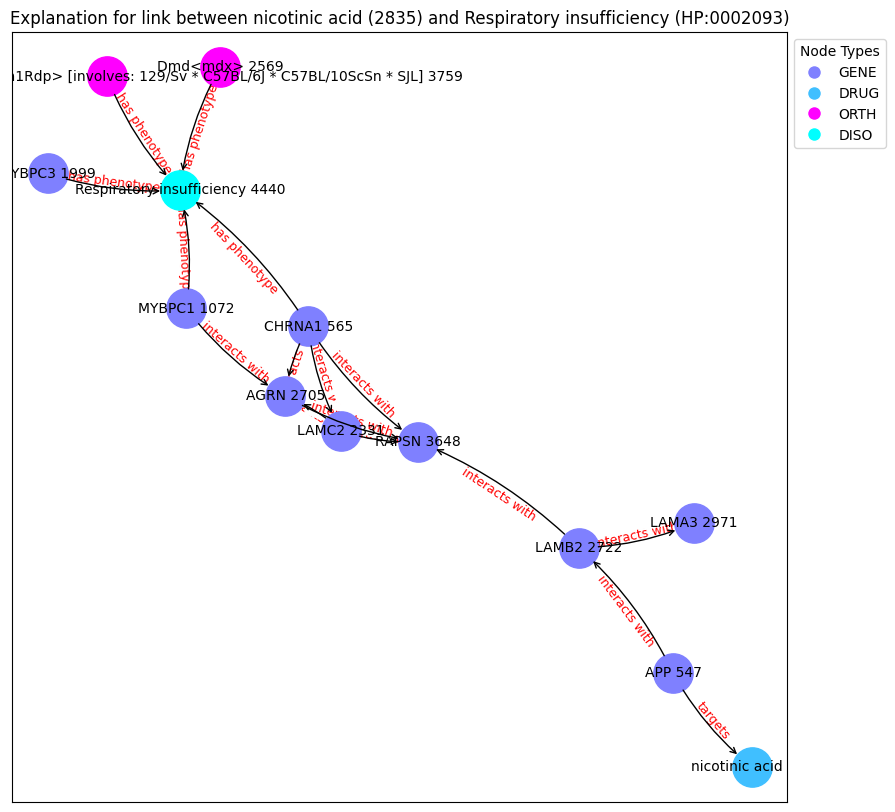

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Respiratory insufficiency (HP:0002093)
  Node Type Percentage  Appearances
0      GENE     61.54%            8
2      ORTH     23.08%            3
1      DRUG      7.69%            1
3      DISO      7.69%            1
        Edge Type Percentage  Appearances
0  interacts with     46.67%            7
2   has phenotype     40.00%            6
1         targets      6.67%            1
3             NaN      6.67%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     46.67%            7
2   (GENE, has phenotype, DISO)     26.67%            4
3   (ORTH, has phenotype, DISO)     13.33%            2
1         (GENE, targets, DRUG)      6.67%            1
4             (ORTH, nan, ORTH)      6.67%            1


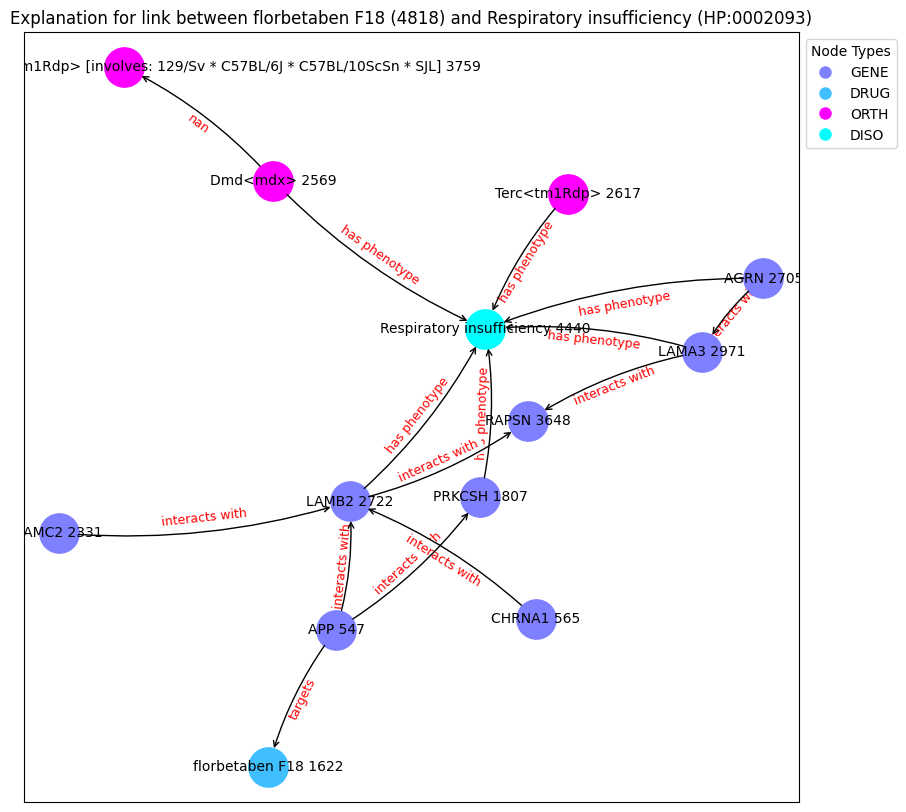

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Skeletal muscle atrophy (HP:0003202)
  Node Type Percentage  Appearances
0      GENE     41.67%            5
1      ORTH     33.33%            4
3      DISO     16.67%            2
2      DRUG      8.33%            1
        Edge Type Percentage  Appearances
2   has phenotype     50.00%            8
0  interacts with     43.75%            7
1         targets      6.25%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     43.75%            7
3   (ORTH, has phenotype, DISO)     25.00%            4
2   (GENE, has phenotype, DISO)     18.75%            3
1         (GENE, targets, DRUG)      6.25%            1
4   (DISO, has phenotype, DISO)      6.25%            1


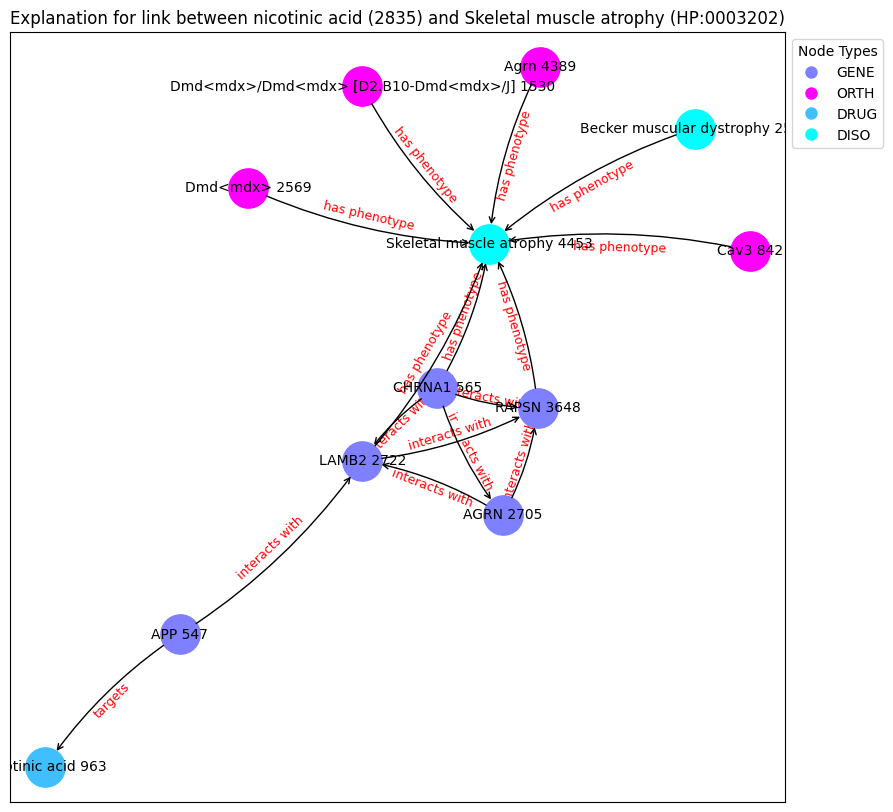

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Skeletal muscle atrophy (HP:0003202)
  Node Type Percentage  Appearances
0      GENE     54.55%            6
2      ORTH     18.18%            2
3      DISO     18.18%            2
1      DRUG      9.09%            1
                               Edge Type Percentage  Appearances
0                         interacts with     43.75%            7
2                          has phenotype     43.75%            7
1                                targets      6.25%            1
3  in 1 to 1 orthology relationship with      6.25%            1
                                            Metapath Percentage  Appearances
0                       (GENE, interacts with, GENE)     43.75%            7
2                        (GENE, has phenotype, DISO)     31.25%            5
1                              (GENE, targets, DRUG)      6.25%            1
3                        (ORTH, has phenotype, DISO)      6.25%            1
4                

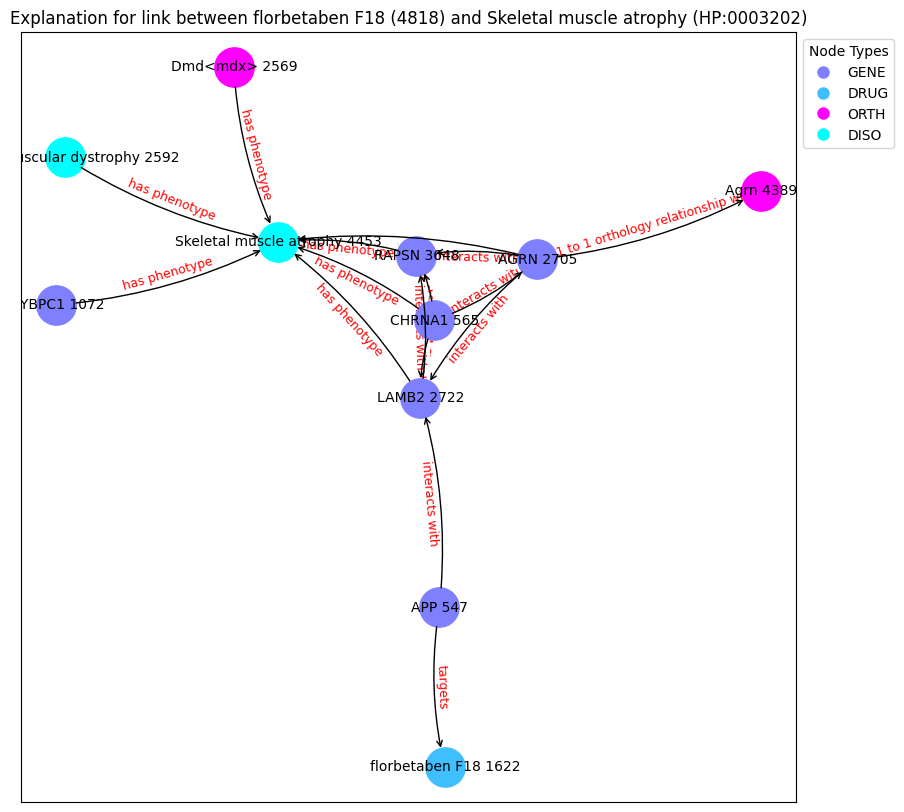

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Scoliosis (HP:0002650)
  Node Type Percentage  Appearances
0      GENE     76.92%           10
1      DRUG      7.69%            1
2      ORTH      7.69%            1
3      DISO      7.69%            1
        Edge Type Percentage  Appearances
0  interacts with     50.00%            8
2   has phenotype     43.75%            7
1         targets      6.25%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     50.00%            8
2   (GENE, has phenotype, DISO)     37.50%            6
1         (GENE, targets, DRUG)      6.25%            1
3   (ORTH, has phenotype, DISO)      6.25%            1


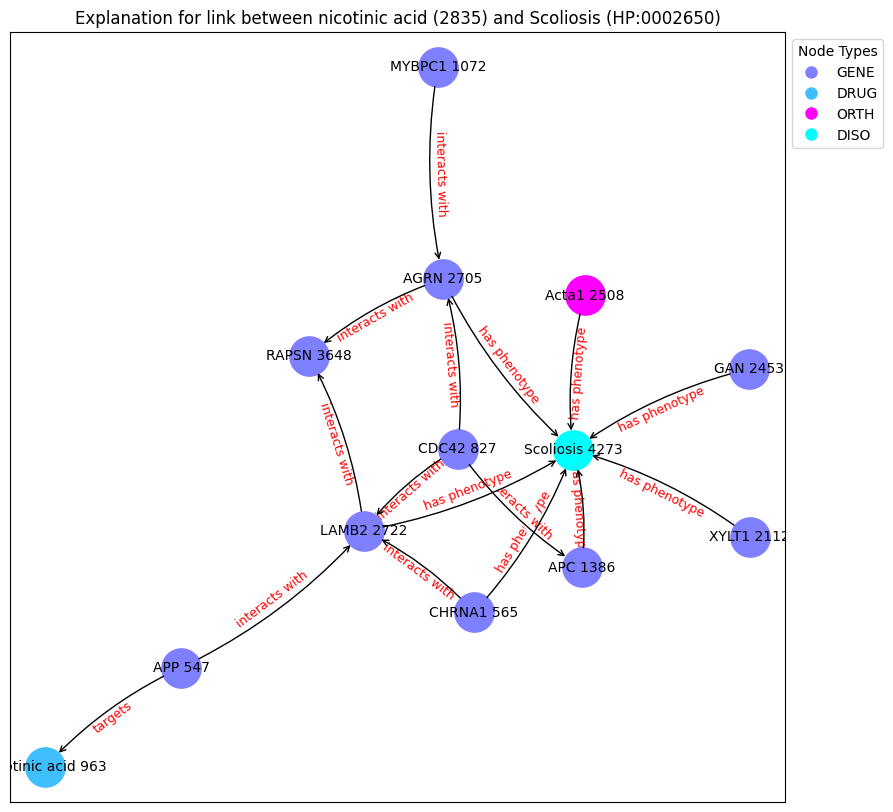

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Scoliosis (HP:0002650)
  Node Type Percentage  Appearances
0      GENE     78.57%           11
1      DRUG      7.14%            1
2      ORTH      7.14%            1
3      DISO      7.14%            1
        Edge Type Percentage  Appearances
0  interacts with     62.50%           10
2   has phenotype     31.25%            5
1         targets      6.25%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     62.50%           10
2   (GENE, has phenotype, DISO)     25.00%            4
1         (GENE, targets, DRUG)      6.25%            1
3   (ORTH, has phenotype, DISO)      6.25%            1


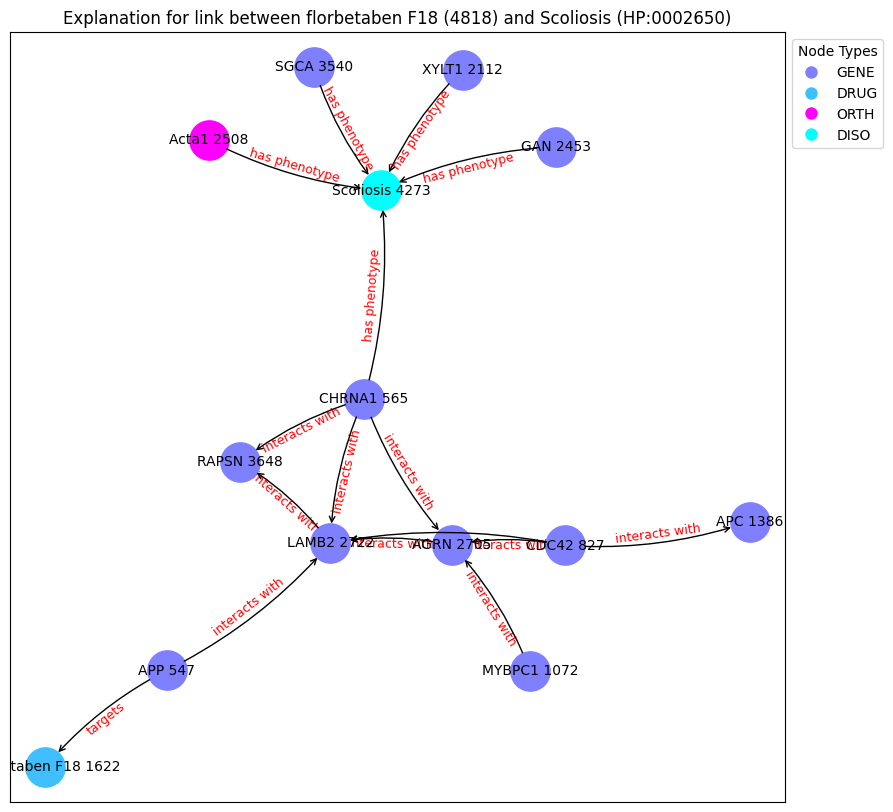

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Global developmental delay (HP:0001263)
  Node Type Percentage  Appearances
0      GENE     81.25%           13
2      DISO     12.50%            2
1      DRUG      6.25%            1
          Edge Type Percentage  Appearances
0    interacts with     56.25%            9
2     has phenotype     31.25%            5
1           targets      6.25%            1
3  causes condition      6.25%            1
                         Metapath Percentage  Appearances
0    (GENE, interacts with, GENE)     56.25%            9
2     (GENE, has phenotype, DISO)     25.00%            4
1           (GENE, targets, DRUG)      6.25%            1
3  (DISO, causes condition, GENE)      6.25%            1
4     (DISO, has phenotype, DISO)      6.25%            1


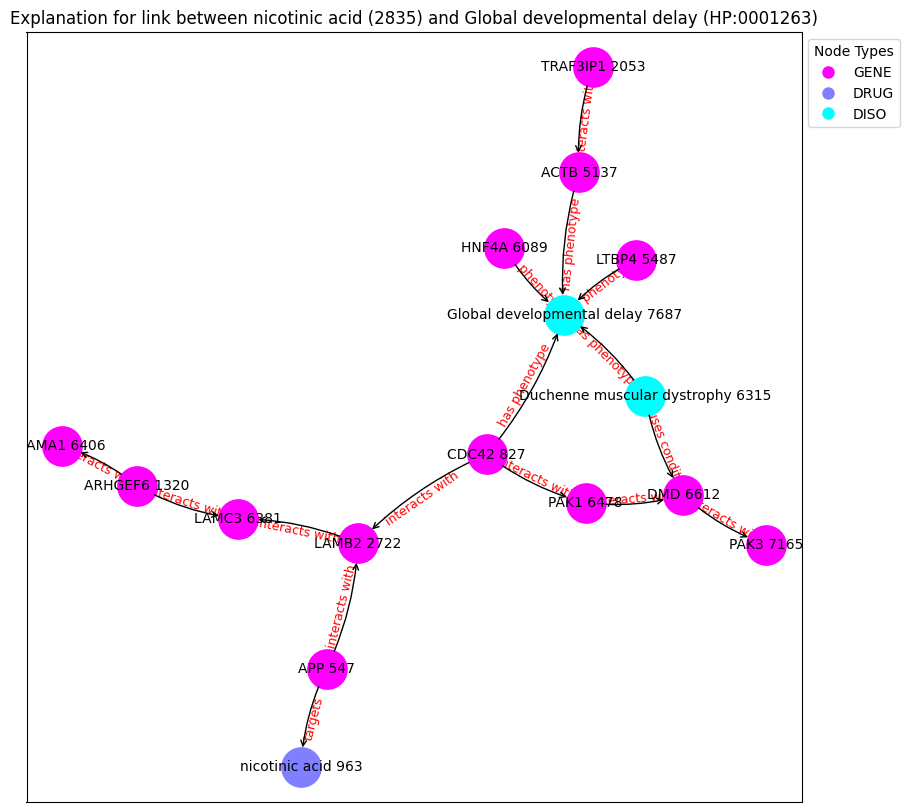

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between carvedilol (522) and Global developmental delay (HP:0001263)
  Node Type Percentage  Appearances
1      GENE     80.00%           12
2      DISO     13.33%            2
0      DRUG      6.67%            1
                        Edge Type Percentage  Appearances
1                  interacts with     66.67%           10
2                   has phenotype     20.00%            3
0                         targets      6.67%            1
3  is causal germline mutation in      6.67%            1
                                       Metapath Percentage  Appearances
1                  (GENE, interacts with, GENE)     66.67%           10
2                   (GENE, has phenotype, DISO)     20.00%            3
0                         (DRUG, targets, GENE)      6.67%            1
3  (GENE, is causal germline mutation in, DISO)      6.67%            1


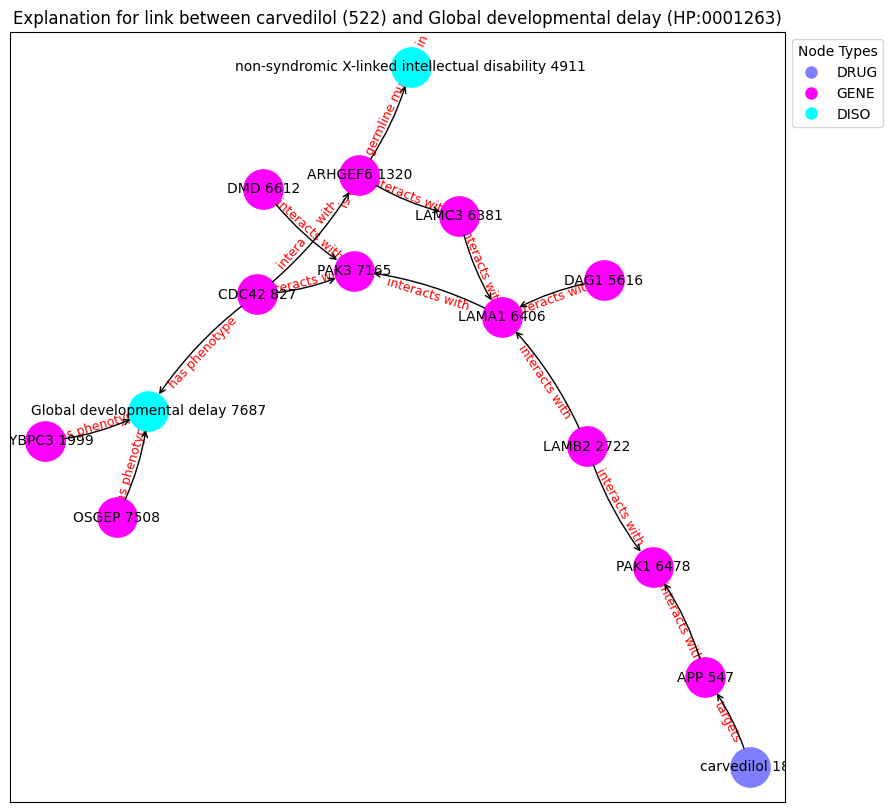

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Global developmental delay (HP:0001263)
  Node Type Percentage  Appearances
0      GENE     80.00%            8
1      DRUG     10.00%            1
2      DISO     10.00%            1
        Edge Type Percentage  Appearances
0  interacts with     70.00%            7
2   has phenotype     20.00%            2
1         targets     10.00%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     70.00%            7
2   (GENE, has phenotype, DISO)     20.00%            2
1         (GENE, targets, DRUG)     10.00%            1


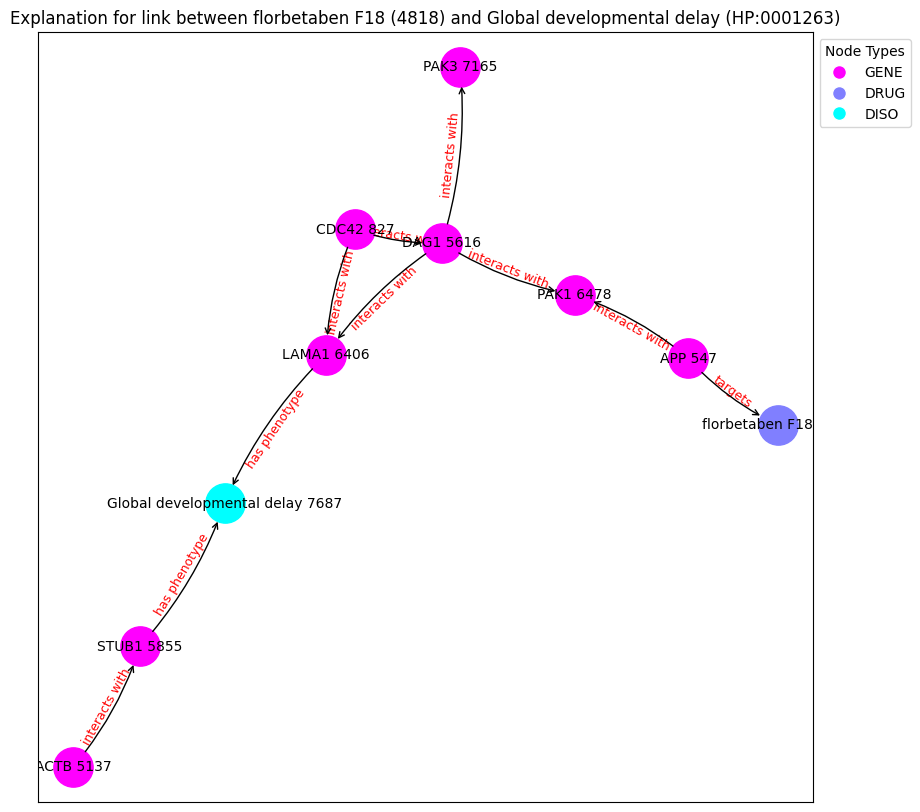

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Hyperlordosis (HP:0003307)
  Node Type Percentage  Appearances
0      GENE     84.62%           11
1      DRUG      7.69%            1
2      DISO      7.69%            1
        Edge Type Percentage  Appearances
0  interacts with     60.00%            9
2   has phenotype     33.33%            5
1         targets      6.67%            1
                       Metapath Percentage  Appearances
0  (GENE, interacts with, GENE)     60.00%            9
2   (GENE, has phenotype, DISO)     33.33%            5
1         (GENE, targets, DRUG)      6.67%            1


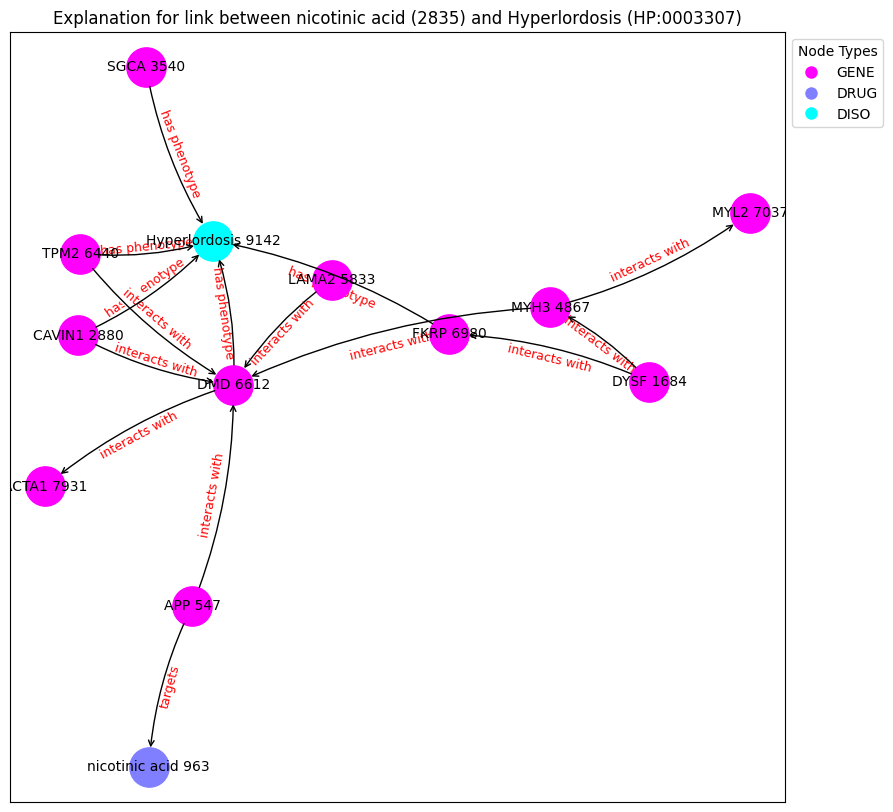

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Hyperlordosis (HP:0003307)
  Node Type Percentage  Appearances
0      GENE     76.92%           10
2      DISO     15.38%            2
1      DRUG      7.69%            1
                                           Edge Type Percentage  Appearances
0                                     interacts with     60.00%            9
2                                      has phenotype     20.00%            3
1                                            targets      6.67%            1
3  is causal germline mutation partially giving r...      6.67%            1
4                                   causes condition      6.67%            1
                                            Metapath Percentage  Appearances
0                       (GENE, interacts with, GENE)     60.00%            9
2                        (GENE, has phenotype, DISO)     20.00%            3
1                              (GENE, targets, DRUG)      6.67%            1
3  

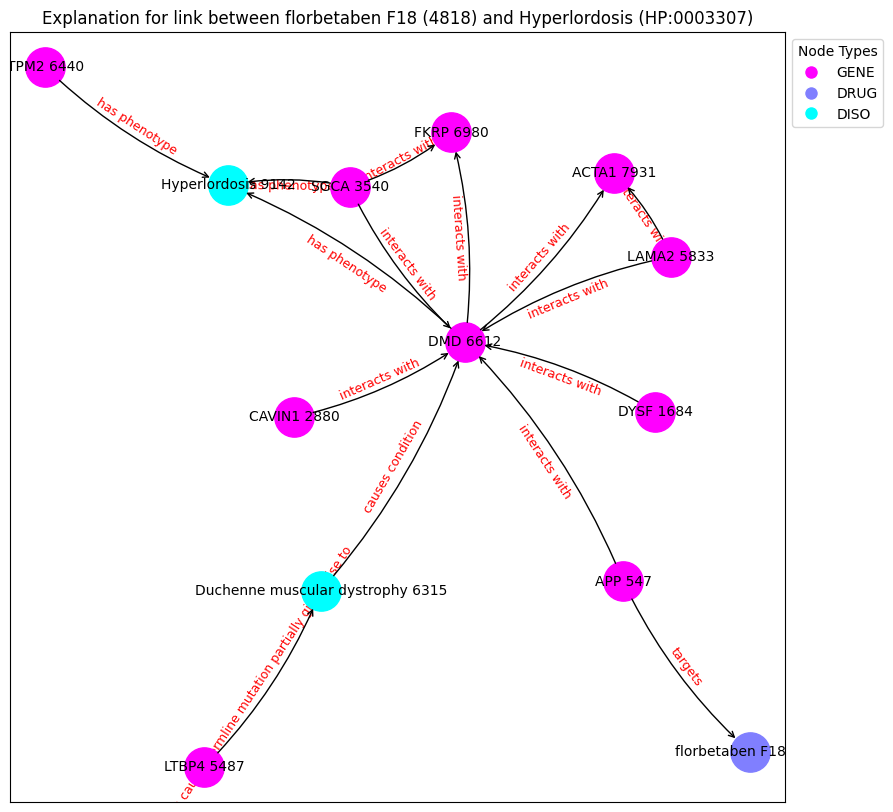

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Delayed speech and language development (HP:0000750)
  Node Type Percentage  Appearances
0      GENE     66.67%            8
2      DISO     25.00%            3
1      DRUG      8.33%            1
                  Edge Type Percentage  Appearances
2             has phenotype     50.00%            8
0            interacts with     37.50%            6
1                   targets      6.25%            1
3  contributes to condition      6.25%            1
                                 Metapath Percentage  Appearances
0            (GENE, interacts with, GENE)     37.50%            6
2             (GENE, has phenotype, DISO)     37.50%            6
4             (DISO, has phenotype, DISO)     12.50%            2
1                   (GENE, targets, DRUG)      6.25%            1
3  (GENE, contributes to condition, DISO)      6.25%            1


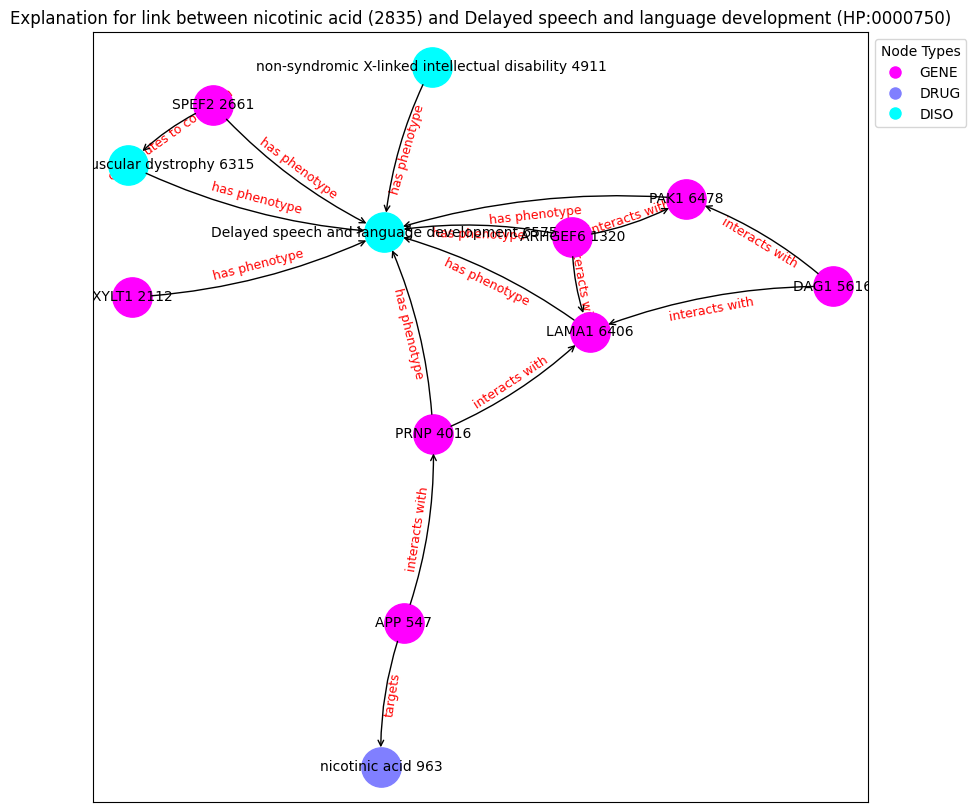

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Delayed speech and language development (HP:0000750)
  Node Type Percentage  Appearances
0      GENE     66.67%            8
2      DISO     25.00%            3
1      DRUG      8.33%            1
                                           Edge Type Percentage  Appearances
0                                     interacts with     50.00%            8
2                                      has phenotype     37.50%            6
1                                            targets      6.25%            1
3  is causal germline mutation partially giving r...      6.25%            1
                                            Metapath Percentage  Appearances
0                       (GENE, interacts with, GENE)     50.00%            8
2                        (GENE, has phenotype, DISO)     25.00%            4
3                        (DISO, has phenotype, DISO)     12.50%            2
1                              (GENE, targets, DRUG)  

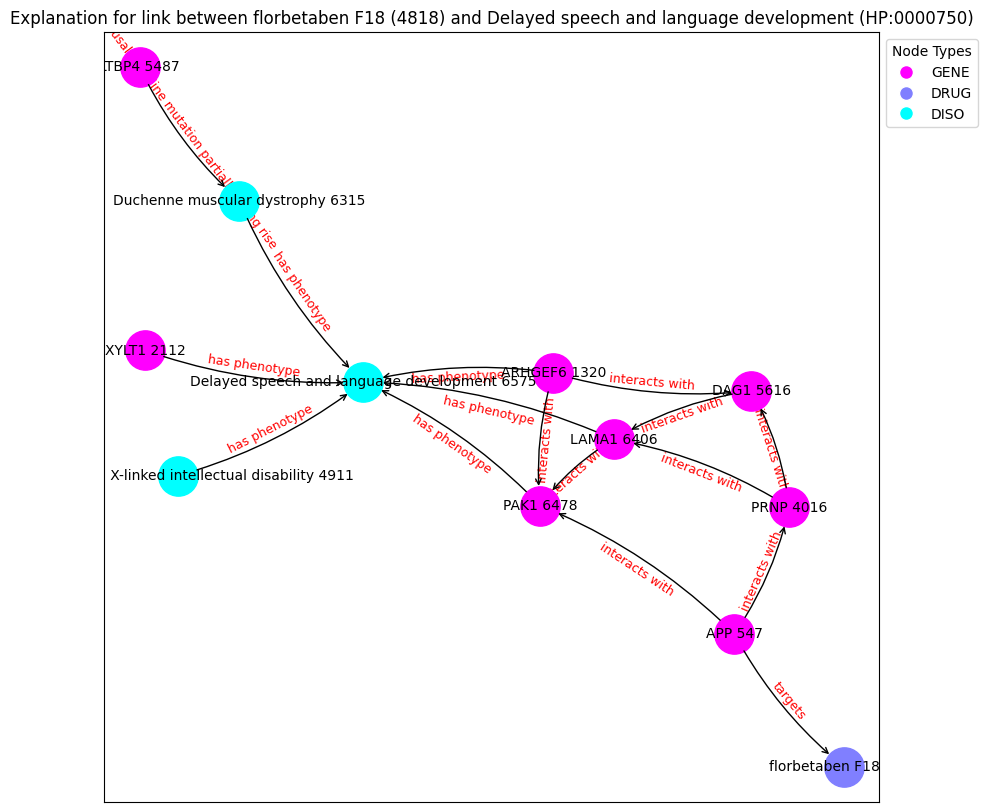

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Hyporeflexia (HP:0001265)
  Node Type Percentage  Appearances
0      GENE     75.00%            9
2      DISO     16.67%            2
1      DRUG      8.33%            1
          Edge Type Percentage  Appearances
0    interacts with     81.25%           13
1           targets      6.25%            1
2  causes condition      6.25%            1
3     has phenotype      6.25%            1
                         Metapath Percentage  Appearances
0    (GENE, interacts with, GENE)     81.25%           13
1           (GENE, targets, DRUG)      6.25%            1
2  (DISO, causes condition, GENE)      6.25%            1
3     (GENE, has phenotype, DISO)      6.25%            1


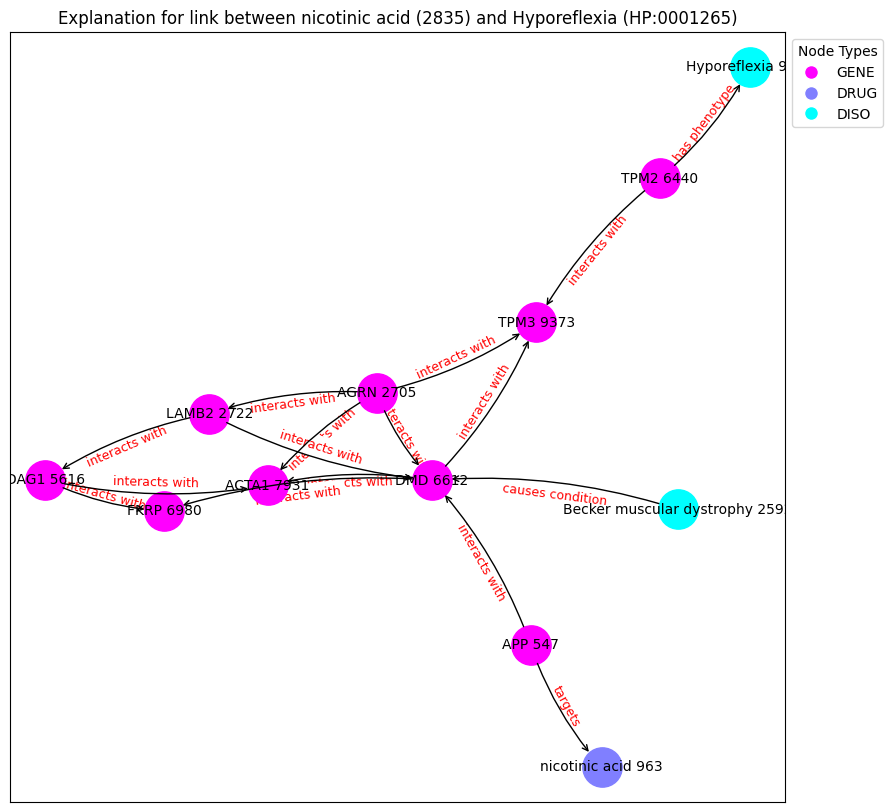

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Hyporeflexia (HP:0001265)
  Node Type Percentage  Appearances
0      GENE     61.54%            8
2      DISO     30.77%            4
1      DRUG      7.69%            1
          Edge Type Percentage  Appearances
0    interacts with     50.00%            8
3     has phenotype     31.25%            5
2  causes condition     12.50%            2
1           targets      6.25%            1
                         Metapath Percentage  Appearances
0    (GENE, interacts with, GENE)     50.00%            8
3     (GENE, has phenotype, DISO)     25.00%            4
2  (DISO, causes condition, GENE)     12.50%            2
1           (GENE, targets, DRUG)      6.25%            1
4     (DISO, has phenotype, DISO)      6.25%            1


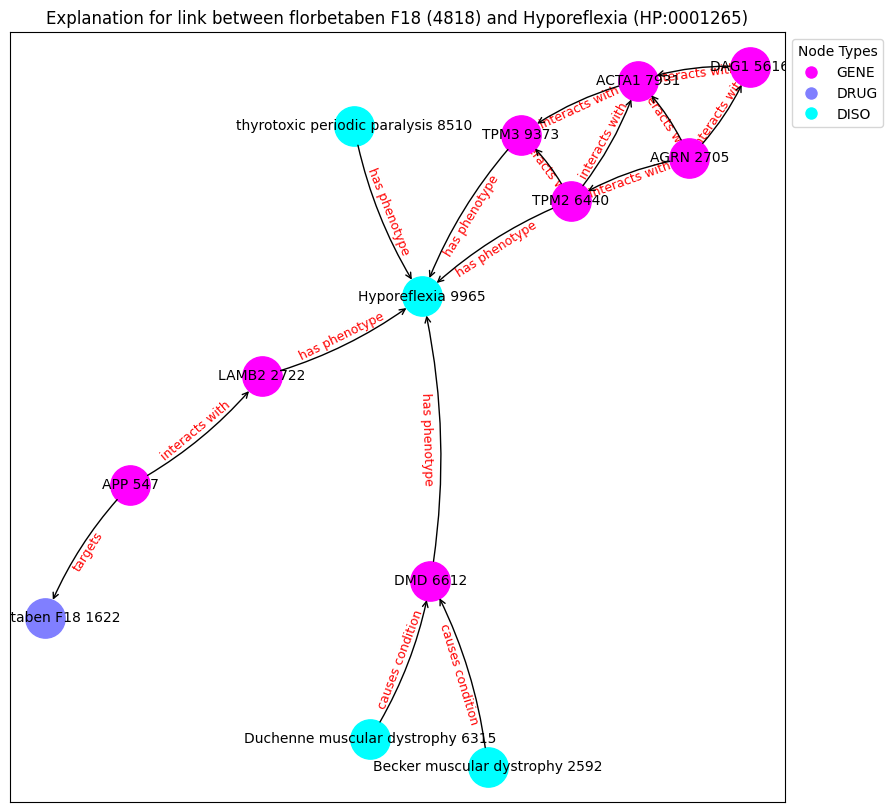

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Generalized hypotonia (HP:0001290)
  Node Type Percentage  Appearances
0      GENE     83.33%           10
1      DRUG      8.33%            1
2      DISO      8.33%            1
        Edge Type Percentage  Appearances
2   has phenotype     56.25%            9
0  interacts with     37.50%            6
1         targets      6.25%            1
                       Metapath Percentage  Appearances
2   (GENE, has phenotype, DISO)     56.25%            9
0  (GENE, interacts with, GENE)     37.50%            6
1         (GENE, targets, DRUG)      6.25%            1


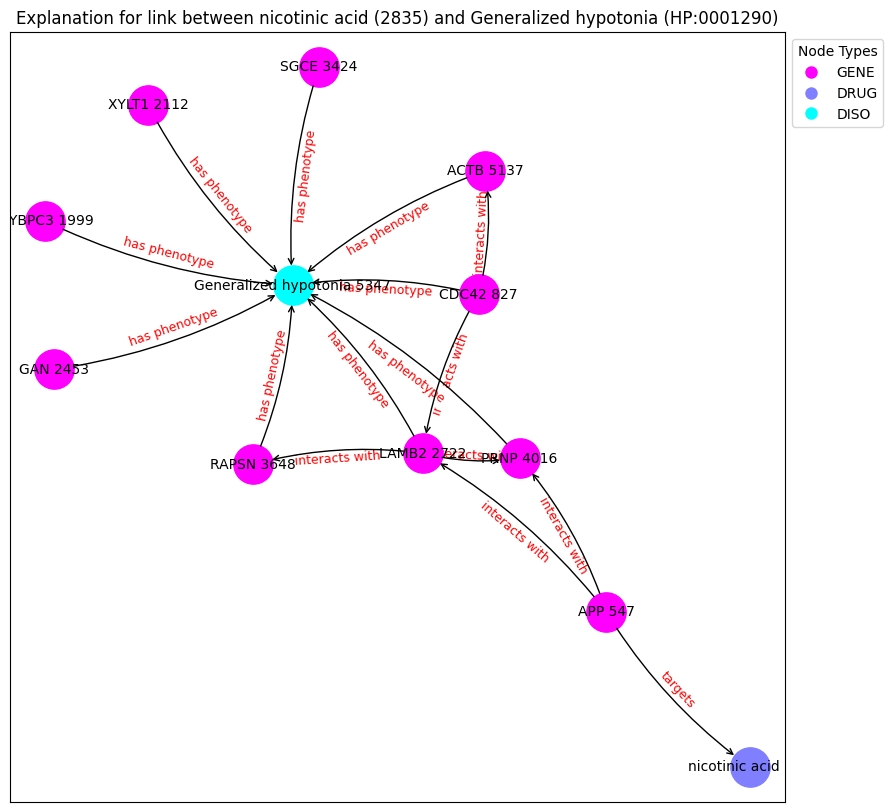

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Generalized hypotonia (HP:0001290)
  Node Type Percentage  Appearances
0      GENE     83.33%           10
1      DRUG      8.33%            1
2      DISO      8.33%            1
        Edge Type Percentage  Appearances
2   has phenotype     56.25%            9
0  interacts with     37.50%            6
1         targets      6.25%            1
                       Metapath Percentage  Appearances
2   (GENE, has phenotype, DISO)     56.25%            9
0  (GENE, interacts with, GENE)     37.50%            6
1         (GENE, targets, DRUG)      6.25%            1


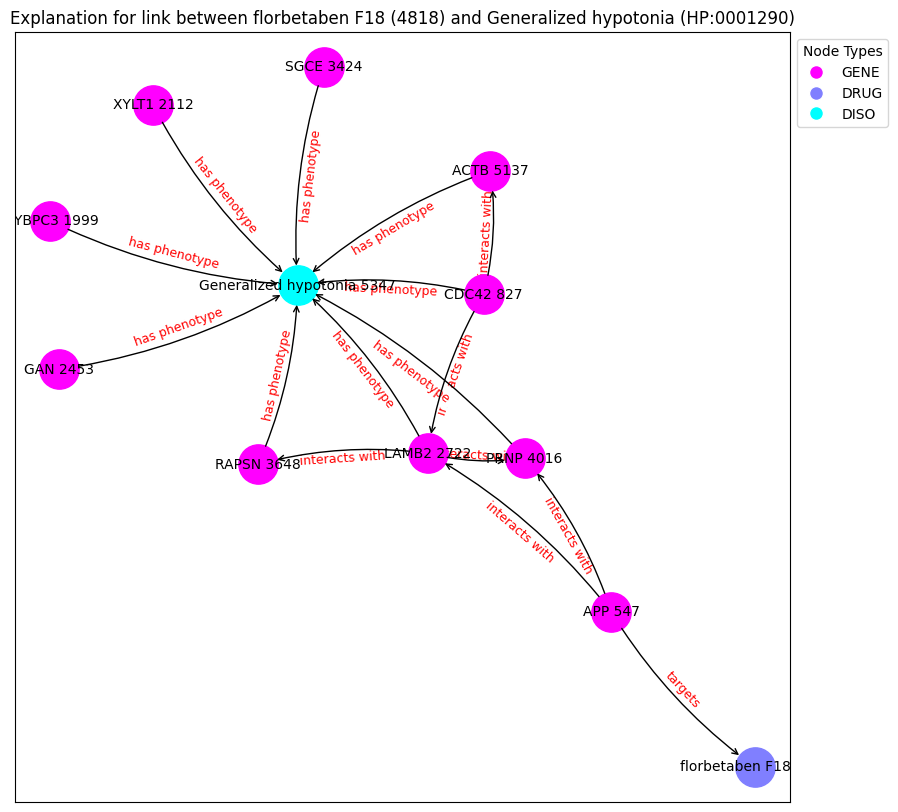

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between nicotinic acid (2835) and Cognitive impairment (HP:0100543)
  Node Type Percentage  Appearances
0      GENE     76.92%           10
2      DISO     15.38%            2
1      DRUG      7.69%            1
          Edge Type Percentage  Appearances
0    interacts with     43.75%            7
2     has phenotype     43.75%            7
1           targets      6.25%            1
3  causes condition      6.25%            1
                         Metapath Percentage  Appearances
0    (GENE, interacts with, GENE)     43.75%            7
2     (GENE, has phenotype, DISO)     37.50%            6
1           (GENE, targets, DRUG)      6.25%            1
3  (DISO, causes condition, GENE)      6.25%            1
4     (DISO, has phenotype, DISO)      6.25%            1


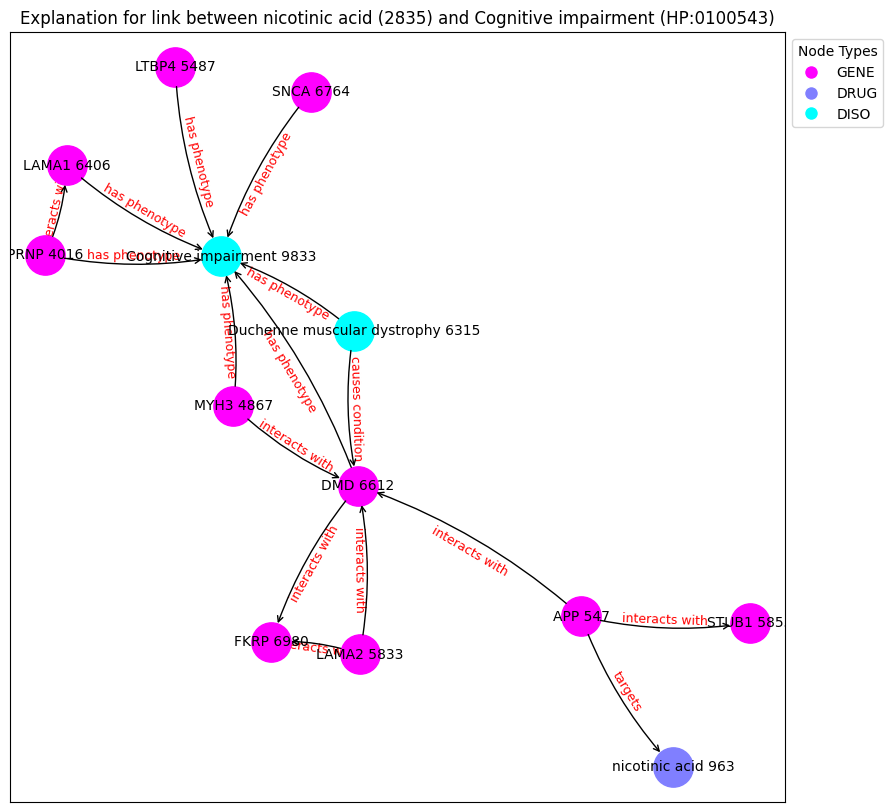

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


Explanation for link between florbetaben F18 (4818) and Cognitive impairment (HP:0100543)
  Node Type Percentage  Appearances
0      GENE     78.57%           11
2      DISO     14.29%            2
1      DRUG      7.14%            1
                                           Edge Type Percentage  Appearances
0                                     interacts with     50.00%            8
2                                      has phenotype     31.25%            5
1                                            targets      6.25%            1
3  is causal germline mutation partially giving r...      6.25%            1
4                           contributes to condition      6.25%            1
                                            Metapath Percentage  Appearances
0                       (GENE, interacts with, GENE)     50.00%            8
2                        (GENE, has phenotype, DISO)     31.25%            5
1                              (GENE, targets, DRUG)      6.25%          

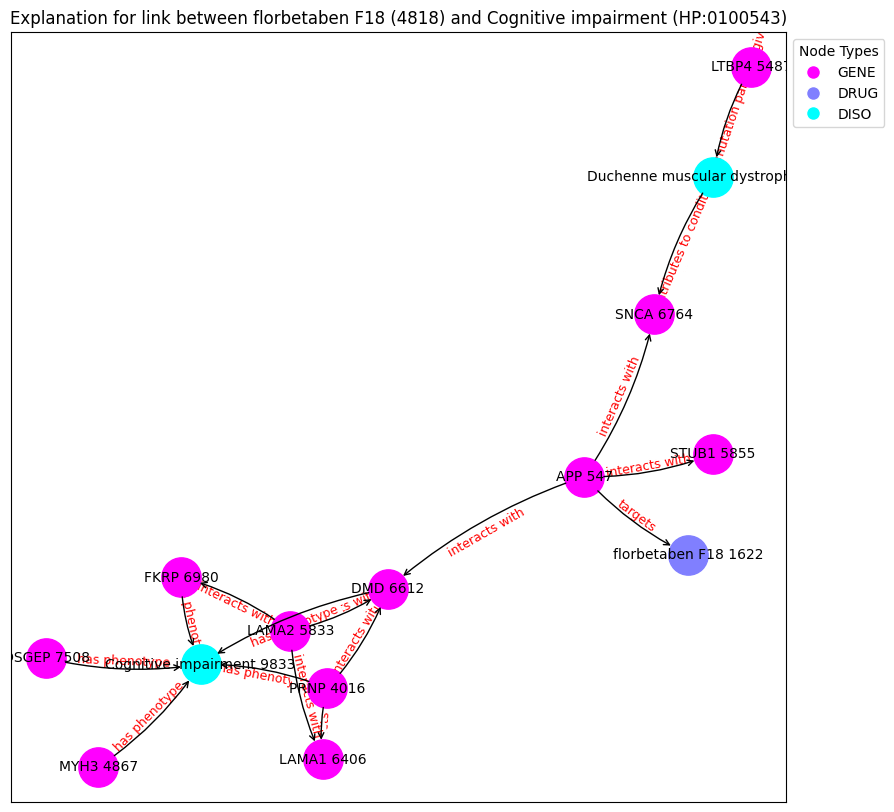

In [26]:
for i, explanation in enumerate(found_explanation):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()
    
    drug_id = explanation['drug']
    drug_name = nodes.loc[nodes['id'] == drug_id]['label'].iloc[0]
    
    symptom_id = explanation['symptom']
    symptom_name = nodes.loc[nodes['id'] == symptom_id]['label'].iloc[0]
    
    explanation_title = f"Explanation for link between {drug_name} ({drug_id}) and {symptom_name} ({symptom_id})"

    plt.figure(figsize=(10, 10))
    plt.title(explanation_title)
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], nodes = nodes, node_labels_dict=node_labels_dict, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = num_hops, threshold=explanation['found_limit'], node_label='label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
    
    print(explanation_title)
    count_occurrences(G_sub)
    plt.show()